In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from ltn_imp.automation.knowledge_base import KnowledgeBase


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Find the Best Hyperparameters

In [ ]:
seed = 42
state = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
dataset = pd.read_csv("datasets/pima_indians_imputed.csv", index_col = 0)
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [ ]:
initilize_models = False

In [ ]:
if initilize_models:
    # Define the models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=state),
        'GradientBoosting': GradientBoostingClassifier(random_state=state),
        'MultiLayerPerceptron': MLPClassifier(random_state=state, max_iter=2000),
        'LogisticRegression': LogisticRegression(random_state=state, max_iter=1000),
        'RandomForest': RandomForestClassifier(random_state=state),
        'KNearestNeighbor': KNeighborsClassifier()
    }

    # Define parameter grids for each model
    param_grids = {
        'DecisionTree': {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [5, 10]
        },
        'GradientBoosting': {
            'n_estimators': np.linspace(50, 250, 5).astype(int),
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        },
        'MultiLayerPerceptron': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100), (30, 30, 30), (50, 30, 20), (100, 50, 25)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive']
        },
        'LogisticRegression': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'RandomForest': {
            'n_estimators': np.linspace(50, 250, 5).astype(int),
            #'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [5, 10, 20],
            'min_samples_leaf': [5, 10]
        },
        'KNearestNeighbor': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }

    # Define the scorer (using recall for refitting as in your example)
    scorer = make_scorer(recall_score)

    # Perform nested cross-validation
    outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    # Iterate over each model to perform grid search and save the best model
    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")
        
        best_recall = 0
        best_model = None
        
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Perform grid search with cross-validation
            clf = GridSearchCV(estimator=model, param_grid=param_grids[model_name], scoring=scorer, refit='recall', cv=inner_cv, n_jobs=-1)
            clf.fit(X_train, y_train)
            
            # Check if this model has a better recall score
            current_recall = recall_score(y_test, clf.predict(X_test))
            if current_recall > best_recall:
                best_recall = current_recall
                best_model = clf.best_estimator_
        
        # Save the best model using pickle if it's better than what was previously found
        if best_model is not None:
            with open(f'models/{model_name}_best_model.pkl', 'wb') as f:
                pickle.dump(best_model, f)
            print(f"Best model for {model_name} saved with recall score of {best_recall:.4f}")
            print()

# Train and Evaluate Models

In [ ]:
def predict(model, x):
    try:
        model.eval()  # Ensure the model is in evaluation mode
    except:
        ""

    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()
        
        # Forward pass through the model
        try:
            probs = model(x)
        except:
            probs = torch.tensor(model.predict(x))

        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_metrics(model, data_loader):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

In [ ]:
kb = KnowledgeBase("medical_config.yaml")

In [ ]:
from sklearn.model_selection import train_test_split

for seed in []

    test_data = pd.read_csv('datasets/pima_indians_imputed.csv', index_col=0).astype(float)

    y = test_data.iloc[:, -1]

    x_train, x_test = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=y)

    x_train.to_csv('datasets/train.csv')
    x_test.to_csv('datasets/test.csv')

    x_train, y_train = x_train.iloc[:, :-1], x_train.iloc[:, -1]
    x_test, y_test = x_test.iloc[:, :-1], x_test.iloc[:, -1]


    models = []

    # Iterate over all files in the "models" folder

    for file_name in os.listdir("models"):
        if file_name.endswith('.pkl'):
            file_path = os.path.join("models", file_name)

            with open(file_path, 'rb') as file:
                # Load the trained model from the pickle file
                trained_model = pickle.load(file)
                
                # Extract the hyperparameters of the loaded model
                model_class = trained_model.__class__
                model_params = trained_model.get_params()
                
                # Reinitialize the model with the same hyperparameters but without the trained state
                new_model = model_class(**model_params)
                
                # Append the reinitialized model to the models list
                models.append(new_model)
                
        elif file_name.endswith('.pth'):
            file_path = os.path.join("models", file_name)
            models.append(torch.load(file_path))
            continue

    X = kb.loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age']]

    Y = kb.loaders[0].loader.dataset.data['Outcome']

    scores= pd.DataFrame([], columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])

    for model in models:
        if hasattr(model,"fit"):
            model.fit(X, Y)
            
        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
        scores.loc[model.__class__.__name__] = [accuracy, precision, recall,f1,balanced_accuracy, mcc]

scores.round(3).sort_values(by="Recall", ascending=False)

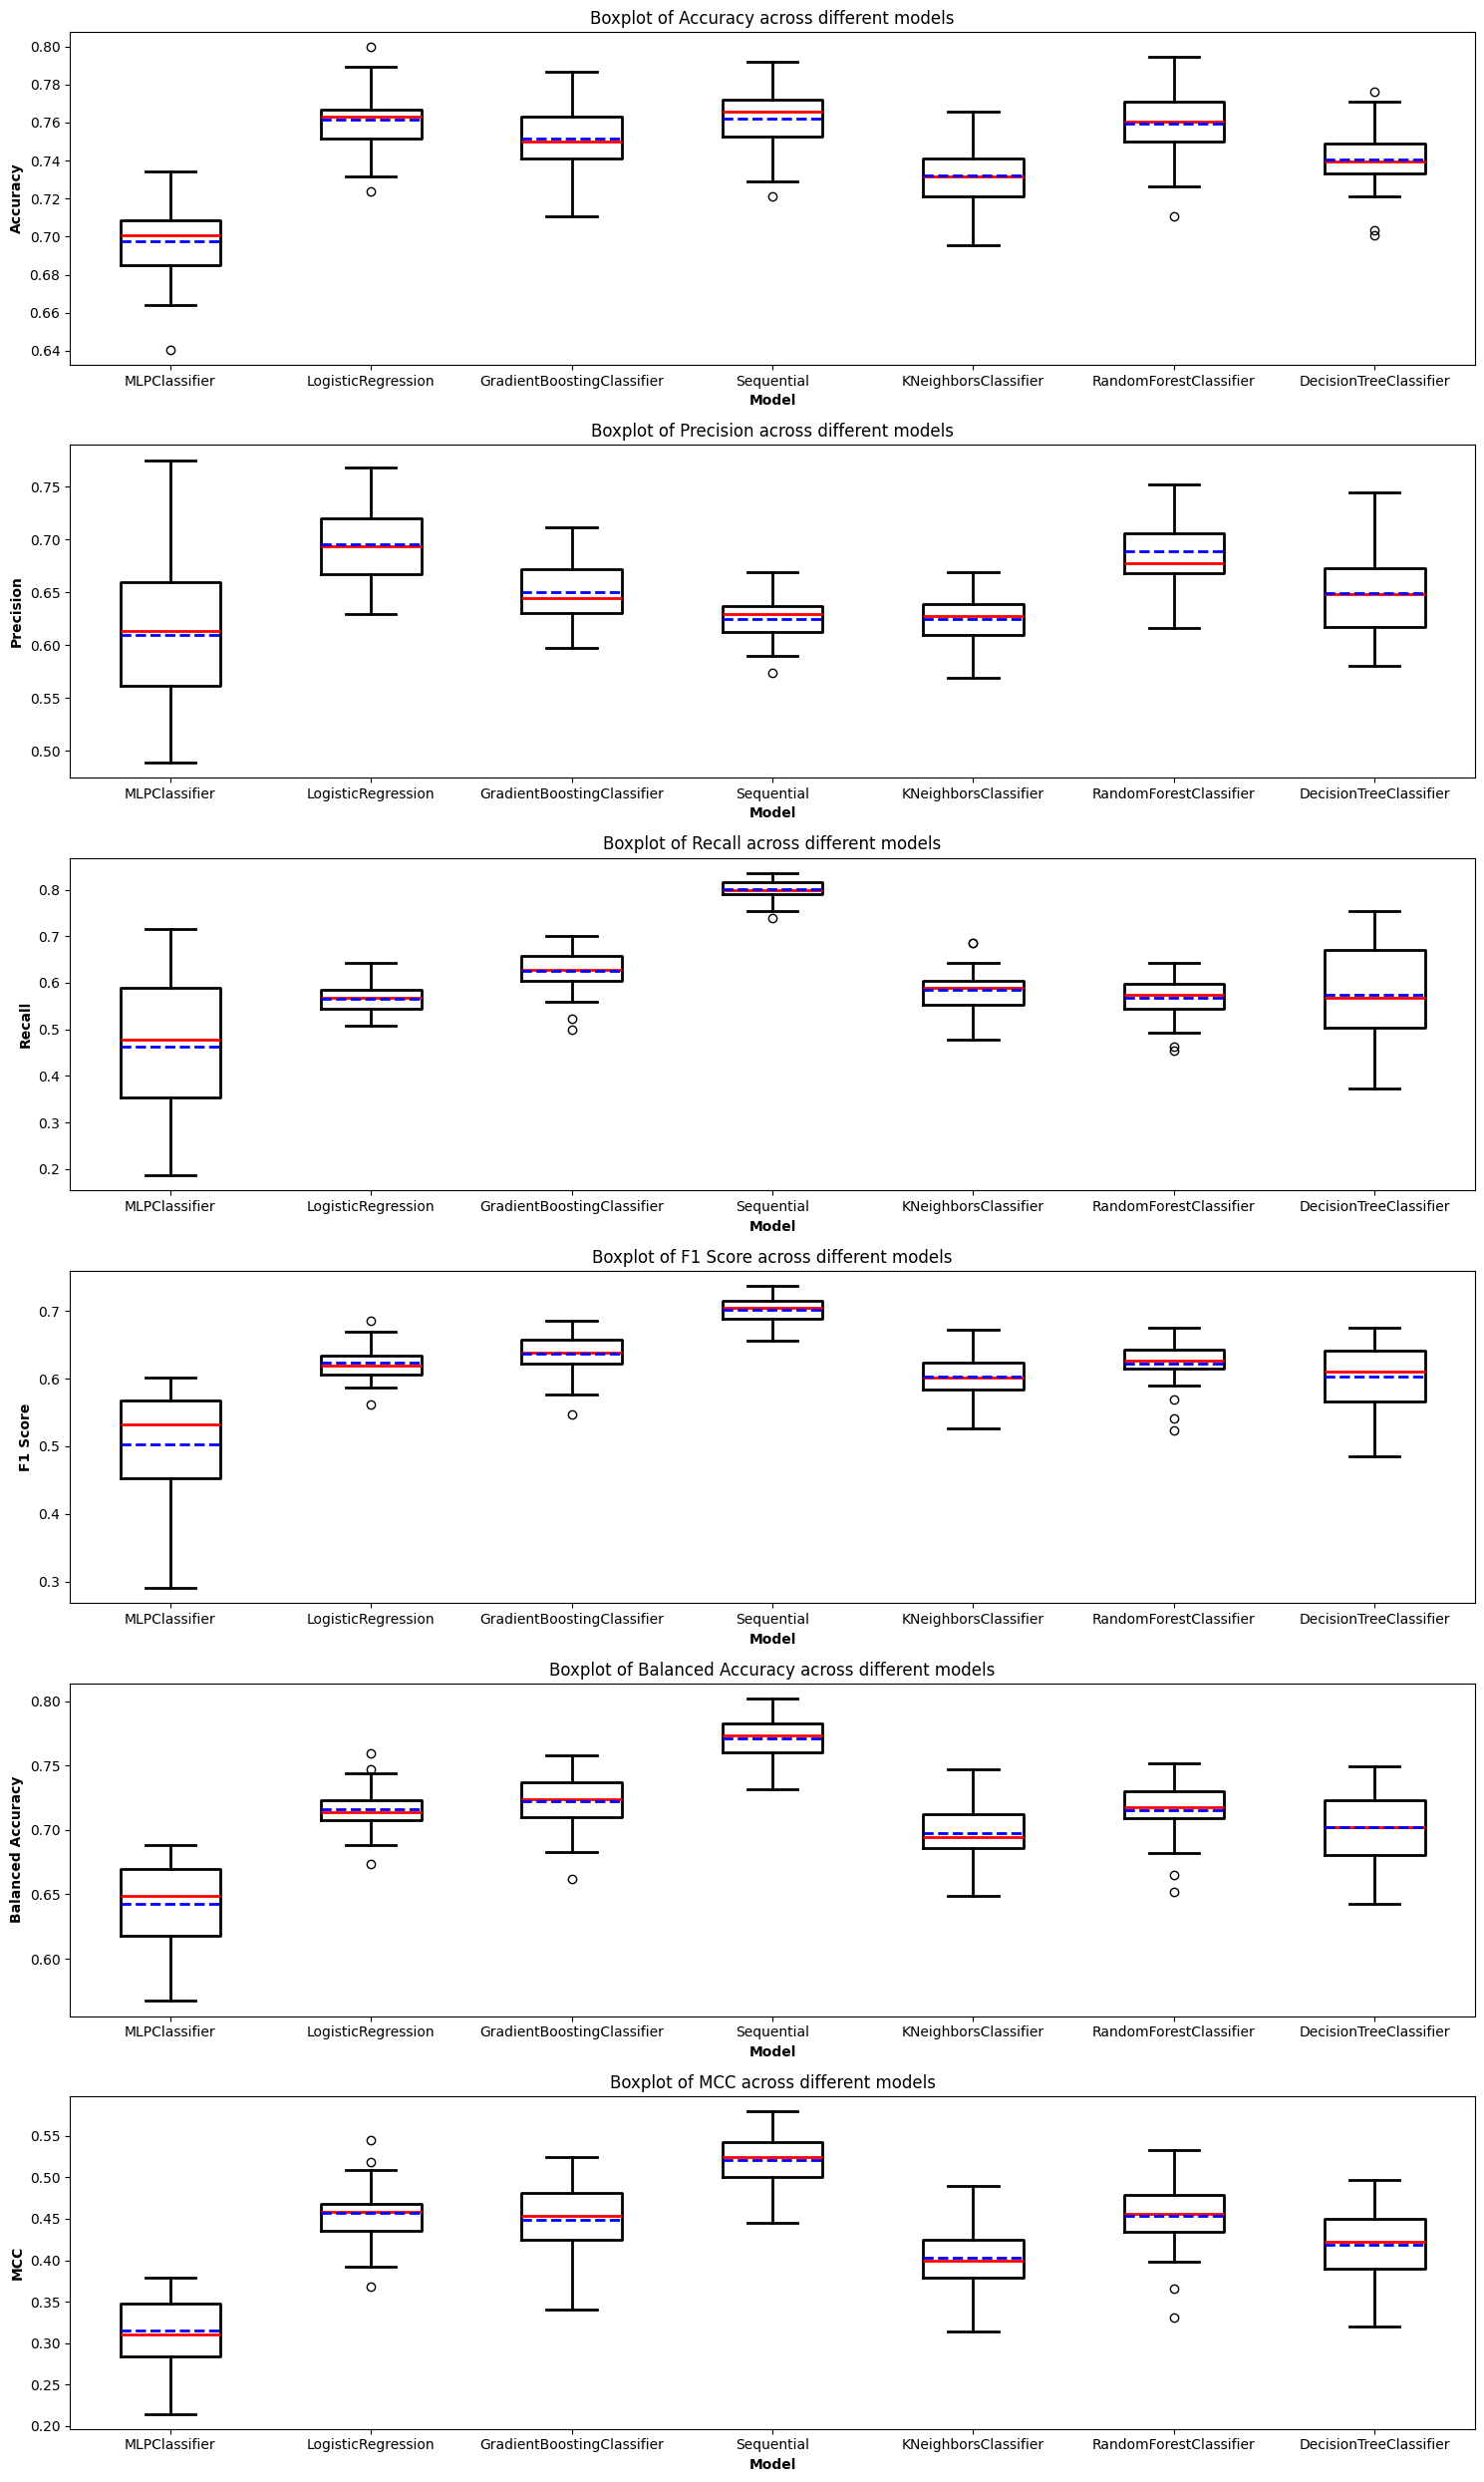

In [69]:
# List of random seeds to test
seeds = [x for x in range(0,31)]

metrics_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])
test_data = pd.read_csv('datasets/pima_indians_imputed.csv', index_col=0).astype(float)
y = test_data.iloc[:, -1]

# Reinitialize the models list for each seed
models = []

# Load models from the "models" folder
for file_name in os.listdir("models"):
    if file_name.endswith('.pkl'):
        file_path = os.path.join("models", file_name)
        with open(file_path, 'rb') as file:
            trained_model = pickle.load(file)
            model_class = trained_model.__class__
            model_params = trained_model.get_params()
            new_model = model_class(**model_params)
            models.append(new_model)
            
    elif file_name.endswith('.pth'):
        file_path = os.path.join("models", file_name)
        models.append(torch.load(file_path))
        continue

# Iterate over each random seed
for seed in seeds:
    # Split the data into training and testing sets
    x_train, x_test = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=y)

    x_train.to_csv('datasets/train.csv')
    x_test.to_csv('datasets/test.csv')

    x_train, y_train = x_train.iloc[:, :-1], x_train.iloc[:, -1]
    x_test, y_test = x_test.iloc[:, :-1], x_test.iloc[:, -1]

    kb = KnowledgeBase("medical_config.yaml")

    X = kb.loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'BMI', 'DiabetesPedigreeFunction', 'Age']]

    Y = kb.loaders[0].loader.dataset.data['Outcome']

    # Evaluate each model
    for model in models:
        model_name = model.__class__.__name__
        if model_name == "Sequential":
            model_name = "Our Model"
        
        # Ensure there is a list initialized for each metric for the model
        if model_name not in metrics_df.index:
            metrics_df.loc[model_name] = [[], [], [], [], [], []]  # Initialize lists for each metric

        if hasattr(model, "fit"):
            model.fit(X, Y)
        
        # Compute metrics using your custom function
        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
        
        # Append the metrics to the corresponding lists in the DataFrame
        metrics_df.loc[model_name, "Accuracy"].append(accuracy)
        metrics_df.loc[model_name, "Precision"].append(precision)
        metrics_df.loc[model_name, "Recall"].append(recall)
        metrics_df.loc[model_name, "F1 Score"].append(f1)
        metrics_df.loc[model_name, "Balanced Accuracy"].append(balanced_accuracy)
        metrics_df.loc[model_name, "MCC"].append(mcc)

# Generate box plots for each metric
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]
plt.figure(figsize=(15, 25))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(6, 1, i)
    data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
    
    # Customize the boxplot
    boxprops = dict(linewidth=2)
    medianprops = dict(linewidth=2, color='red')
    meanprops = dict(linewidth=2, color='blue')
    whiskerprops = dict(linewidth=2)
    capprops = dict(linewidth=2)
    
    plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                medianprops=medianprops, meanline=True, showmeans=True, 
                meanprops=meanprops, whiskerprops=whiskerprops, 
                capprops=capprops)
    
    plt.title(f'Boxplot of {metric} across different models')
    plt.xlabel('Model', fontweight='bold')
    plt.ylabel(metric, fontweight='bold')

plt.tight_layout()
plt.show()

In [82]:
import numpy as np
import scipy.stats as stats

best_models = {}
for metric in metrics_df.columns:
    mean_scores = metrics_df[metric].apply(np.mean)
    best_model = mean_scores.idxmax()  
    best_models[metric] = best_model

results = {}
for metric in metrics_df.columns:
    best_model = best_models[metric]
    best_scores = metrics_df.loc[best_model, metric]
    
    results[metric] = {}
    
    for model_name in metrics_df.index:
        if model_name == best_model:
            continue
        
        comparison_scores = metrics_df.loc[model_name, metric]
        t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
        results[metric][model_name] = p_value 

significance_level = 0.05
for metric, comparisons in results.items():
    print(f"\n{metric}:")
    best_model = best_models[metric]
    for model_name, p_value in comparisons.items():
        if p_value < significance_level:
            print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
        else:
            print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")



Accuracy:
  Sequential is significantly better than MLPClassifier (p = 0.0000)
  Sequential is NOT significantly better than LogisticRegression (p = 0.7360)
  Sequential is significantly better than GradientBoostingClassifier (p = 0.0081)
  Sequential is significantly better than KNeighborsClassifier (p = 0.0000)
  Sequential is NOT significantly better than RandomForestClassifier (p = 0.4019)
  Sequential is significantly better than DecisionTreeClassifier (p = 0.0000)

Precision:
  LogisticRegression is significantly better than MLPClassifier (p = 0.0000)
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than Sequential (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is NOT significantly better than RandomForestClassifier (p = 0.2818)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)

Recall:
  